# Visualization

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as np
from jax import grad, vmap, jacfwd
from scipy.stats import kde
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")

import distributions
import plot

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
density = distributions.banana

<ipython-input-3-5c1700dc8bee>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(*plot.make_meshgrid(density.pdf, lims=(-10,10)))


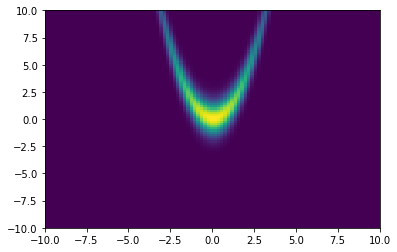

In [3]:
plt.pcolormesh(*plot.make_meshgrid(density.pdf, lims=(-10,10)))

<ipython-input-4-16cc652756da>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(*plot.make_meshgrid(density.logpdf, lims=(-10,10)), vmin=-15, vmax=0)


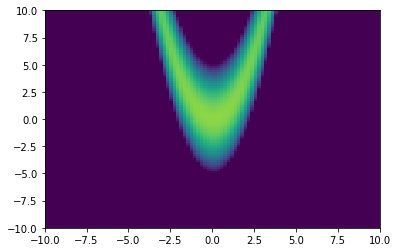

In [4]:
plt.pcolormesh(*plot.make_meshgrid(density.logpdf, lims=(-10,10)), vmin=-15, vmax=0)

In [5]:
grad_density1 = grad(density.pdf)
def grad_density(x, y):
    return grad_density1(np.append(x, y))

In [6]:
def quiverplot(f, num_gridpoints=50, lims=[-10, 10], xlims=None, ylims=None, angles="xy", scale=2, **kwargs):
    """
    Plot a vector field. f is a function f: R^2 ---> R^2
    If arrows are too large, change scale (larger scale = shorter arrows)
    """
    if xlims is None:
        xlims = lims
    if ylims is None:
        ylims = lims

    def split_f(x, y):
        return f(np.append(x, y))

    x = np.linspace(*xlims, num_gridpoints)
    y = np.linspace(*ylims, num_gridpoints)
    xx, yy = np.meshgrid(x, y, dtype=np.float32)
    zz = vmap(vmap(split_f))(xx, yy)
    uu, vv = np.rollaxis(zz, 2)

    plt.quiver(xx, yy, uu, vv, angles=angles, scale=scale, **kwargs)

<ipython-input-7-09c3473a7541>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(*plot.make_meshgrid(density.pdf, lims=(-10,10)))


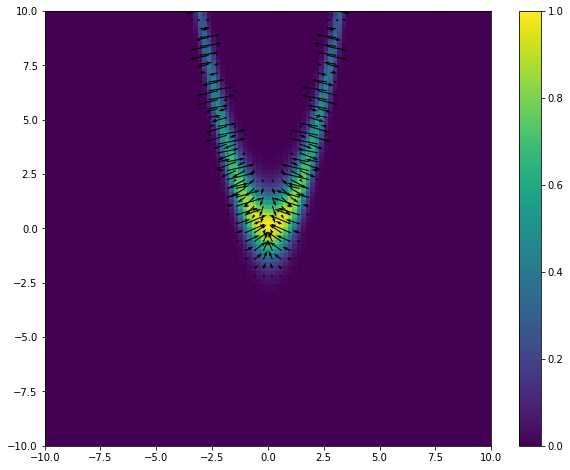

In [7]:
plt.subplots(figsize=[10,8])
plt.pcolormesh(*plot.make_meshgrid(density.pdf, lims=(-10,10)))
quiverplot(grad_density1)
plt.colorbar()